In [1]:
%matplotlib inline

# Import Dataset

In [347]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# read in the csv file
diabetic_ds = pd.read_csv('/Users/ethan.graham/Desktop/MSDS 6120 Capstone A/diabetic_data.csv') 

print(len(diabetic_ds))
# Would be nice to include weight, but the data is mostly missing
categoryColumnNames = [
    'discharge_disposition_id',
    'admission_type_id',
    'admission_source_id',
    'insulin',
    'race',
    'gender',
    'diabetesMed'
]

scalarColumnNames = [
    'age',
    'time_in_hospital',
    'number_diagnoses'
]

diabetic = diabetic_ds[np.concatenate((categoryColumnNames, scalarColumnNames, ['readmitted']))]
del diabetic_ds

# Drop samples with missing data.
diabetic = diabetic.replace('?', np.nan).dropna(subset = ['race'], how = 'all')

# Replace missing gender values with the gender mode
diabetic['gender'].replace(to_replace ='Unknown/Invalid', value = diabetic['gender'].mode()[0], inplace = True)

for col in np.concatenate((categoryColumnNames, scalarColumnNames)):
    assert col in diabetic 

print(diabetic.gender.value_counts())

101766
99493
Female    53576
Male      45917
Name: gender, dtype: int64


In [239]:
from sklearn.preprocessing import StandardScaler

# Replace age as numeric based on the range string
diabetic['age'].replace(to_replace = {'[0-10)'   : np.uint8(1),
                                      '[10-20)'  : np.uint8(2),
                                      '[20-30)'  : np.uint8(3),
                                      '[30-40)'  : np.uint8(4),
                                      '[40-50)'  : np.uint8(5),
                                      '[50-60)'  : np.uint8(6),
                                      '[60-70)'  : np.uint8(7),
                                      '[70-80)'  : np.uint8(8),
                                      '[80-90)'  : np.uint8(9),
                                      '[90-100)' : np.uint8(10)}, inplace = True)

for colName in categoryColumnNames:
    diabetic[colName] = diabetic[colName].astype('category')

# Will be usefull later so save the dict now
readmittedDict = {'NO'  : np.uint8(0),
                  '<30' : np.uint8(1),
                  '>30' : np.uint8(0)} # readmissions after 30 days don't count

diabetic['readmitted'].replace(to_replace = readmittedDict, inplace = True)

for colName in scalarColumnNames:
    assert np.any(np.isnan(diabetic[colName].values)) == False, colName

# Avoid scaling dummy variables: 
# https://stats.stackexchange.com/questions/381643/scale-dummy-variables-in-logistic-regression
diabeticScaled = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(diabetic[scalarColumnNames]),
                              columns = scalarColumnNames, index = diabetic.index)

for colName in scalarColumnNames:
    del diabetic[colName]


# Add dummy variables to the data set
dummies = pd.get_dummies(
                      diabetic[categoryColumnNames],
                      drop_first = True # Avoid multicolinearity in the dummy columns
)

for df in [dummies, diabeticScaled]:
    for colName, data in df.iteritems():
        assert np.any(np.isnan(data)) == False, colName
        # Careful when assigning new columns in a DataFrame:
        # https://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas
        data.index = diabetic.index
        diabetic[colName] = data
        assert len(data) == len(diabetic[colName])
        assert np.any(np.isnan(diabetic[colName].values)) == False, colName


for colName in scalarColumnNames:
    assert np.any(np.isnan(diabetic[colName].values)) == False, colName

# Check results
print(tabulate({x : diabetic[x].unique() for x in categoryColumnNames}, headers = 'keys'))
print({x : diabetic[x].mean() for x in scalarColumnNames})
print(diabetic.readmitted.value_counts())

# Delete redundant variables
for colName in categoryColumnNames:
    del diabetic[colName]

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


  discharge_disposition_id    admission_type_id    admission_source_id  insulin    race             gender    diabetesMed
--------------------------  -------------------  ---------------------  ---------  ---------------  --------  -------------
                        25                    6                      1  No         Caucasian        Female    No
                         1                    1                      7  Up         AfricanAmerican  Male      Yes
                         3                    2                      2  Steady     Other
                         6                    3                      4  Down       Asian
                         2                    4                      5             Hispanic
                         5                    5                      6
                        11                    8                     20
                         7                    7                      3
                        10                  

In [240]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99493 entries, 0 to 101765
Data columns (total 61 columns):
readmitted                     99493 non-null int64
discharge_disposition_id_2     99493 non-null uint8
discharge_disposition_id_3     99493 non-null uint8
discharge_disposition_id_4     99493 non-null uint8
discharge_disposition_id_5     99493 non-null uint8
discharge_disposition_id_6     99493 non-null uint8
discharge_disposition_id_7     99493 non-null uint8
discharge_disposition_id_8     99493 non-null uint8
discharge_disposition_id_9     99493 non-null uint8
discharge_disposition_id_10    99493 non-null uint8
discharge_disposition_id_11    99493 non-null uint8
discharge_disposition_id_12    99493 non-null uint8
discharge_disposition_id_13    99493 non-null uint8
discharge_disposition_id_14    99493 non-null uint8
discharge_disposition_id_15    99493 non-null uint8
discharge_disposition_id_16    99493 non-null uint8
discharge_disposition_id_17    99493 non-null uint8
discha

{0.6272117235563558,
 1.2544234471127116,
 1.8816351706690673,
 2.508846894225423,
 3.136058617781779,
 3.7632703413381345,
 4.39048206489449,
 5.017693788450846,
 5.644905512007202,
 6.272117235563558}

In [243]:
limitedColumns = diabetic[['discharge_disposition_id_6',
'discharge_disposition_id_11',
'discharge_disposition_id_13',
'discharge_disposition_id_14',
'discharge_disposition_id_22',
'admission_type_id_2',
'admission_type_id_3',
'admission_type_id_5',
'admission_type_id_6',
'admission_source_id_4',
'admission_source_id_6',
'admission_source_id_7',
'insulin_No',
'insulin_Steady',
'insulin_Up',
'race_Caucasian',
'gender_Male',
'diabetesMed_Yes',
'age',
'time_in_hospital',
'number_diagnoses', 'readmitted']]


In [237]:
set(diabetic['age'])

{0.6272117235563558,
 1.2544234471127116,
 1.8816351706690673,
 2.508846894225423,
 3.136058617781779,
 3.7632703413381345,
 4.39048206489449,
 5.017693788450846,
 5.644905512007202,
 6.272117235563558}

In [338]:
svc = LinearSVC(class_weight = 'balanced', # adjust weights inversely proportional to class frequencies in the data set
                fit_intercept = True, #  If set to false, no intercept will be used in calculations
                                       # (i.e. data is expected to be already centered).
                max_iter = 10000, # default=1000
                penalty = 'l2', # The ‘l1’ leads to coef_ vectors that are sparse.
                dual = True,
                random_state = rState)

if 'readmitted' in limitedColumns:
    y = limitedColumns['readmitted'].values # get the labels we want
    del limitedColumns['readmitted'] # get rid of the class label
    X = limitedColumns.values # use everything else to predict!

rState = RandomState(seed = 4428120)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.1,
    stratify = y, # split so population proportions are preserved in samples
    random_state = rState # Random state is preferred for reproducability
)

svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2',
     random_state=<mtrand.RandomState object at 0x1a2e5b3c60>, tol=0.0001,
     verbose=0)

In [339]:
#calc_cumulative_gains(probabilit_col = svc.decision_function(X))

lift = calc_cumulative_gains(
    df = pd.DataFrame({'actual': y_test, 'predict': svc.predict(X_test), 'probability':svc.decision_function(X_test)}),
    actual_col = 'actual',
    predicted_col = 'predict',
    probability_col ='probability')
                      

In [342]:
[int((label+1)*10) for label in [float(item.get_text()) for item in bar.get_xticklabels()]]

[10, 12, 14, 16, 18, 20]

In [334]:
lift

,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
1,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
2,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
3,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
4,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
5,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
6,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
7,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
8,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN
9,0,0,0,NaN,0,NaN,0.0,0.0,NaN,1,NaN


0.0
0.2
0.4
0.6
0.8
1.0






/anaconda/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


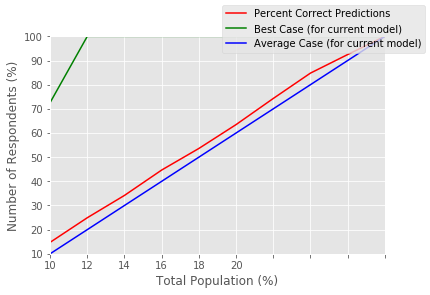

In [344]:
plot_cumulative_gains(lift)

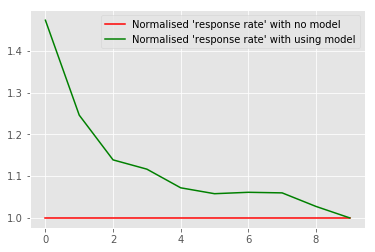

In [346]:
plot_lift_chart(lift)

In [345]:
def plot_lift_chart(lift: pd.DataFrame):
    plt.figure()
    plt.plot(lift['NormalisedPercentAvg'], 'r-', label='Normalised \'response rate\' with no model')
    plt.plot(lift['NormalisedPercentWithModel'], 'g-', label='Normalised \'response rate\' with using model')
    plt.legend()
    plt.show()

In [250]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    #https://stackoverflow.com/questions/42699243/how-to-build-a-lift-chart-a-k-a-gains-chart-in-python
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [343]:
import matplotlib.pyplot as plt
def plot_cumulative_gains(lift: pd.DataFrame):
    fig, ax = plt.subplots()
    fig.canvas.draw()

    handles = []
    handles.append(ax.plot(lift['PercentCorrect'], 'r-', label='Percent Correct Predictions'))
    handles.append(ax.plot(lift['PercentCorrectBestCase'], 'g-', label='Best Case (for current model)'))
    handles.append(ax.plot(lift['PercentAvgCase'], 'b-', label='Average Case (for current model)'))
    ax.set_xlabel('Total Population (%)')
    ax.set_ylabel('Number of Respondents (%)')

    ax.set_xlim([0, 9])
    ax.set_ylim([10, 100])
    for label in ax.get_xticklabels():
        print(label.get_text())
    #print(item.get_text() for item in ax.get_xticklabels())
    labels =  [10, 12, 14, 16, 18, 20]#[int((label+1)*10) for label in [float(item.get_text()) for item in ax.get_xticklabels()]]

    ax.set_xticklabels(labels)

    fig.legend(handles, labels=[h[0].get_label() for h in handles])
    fig.show()

# Train model

In [188]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from numpy.random import RandomState
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
import time

if 'readmitted' in diabetic:
    y = diabetic['readmitted'].values # get the labels we want
    del diabetic['readmitted'] # get rid of the class label
    X = diabetic.values # use everything else to predict!

rState = RandomState(seed = 4428120)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.66667,
    stratify = y, # split so population proportions are preserved in samples
    random_state = rState # Random state is preferred for reproducability
)

assert np.any(np.isnan(X)) == False
assert np.all(np.isfinite(X)) == True
assert np.any(np.isnan(y)) == False
assert np.all(np.isfinite(y)) == True
assert np.any(np.isnan(X_train)) == False
assert np.any(np.isnan(y_train)) == False

# Set the parameters by cross-validation
# Imballanced data can affect the training of XGBoost model, and there are two ways to improve it.
#
# If you care only about the overall performance metric (AUC) of your prediction
## Balance the positive and negative weights via scale_pos_weight
## Use AUC for evaluation
# If you care about predicting the right probabilityIn such a case, you cannot re-balance the dataset
## Set parameter max_delta_step to a finite number (say 1) to help convergence
# https://www.saedsayad.com/model_evaluation_c.htm
# Set parameter max_delta_step to a finite number (say 1) to help convergence
tuned_parameters = [{'max_depth' : [3],
                    'min_child_weight' : [2],
                    'n_estimators' : [50],
                    'silent' : [True],
                    'objective' : 
                         ['binary:logistic', # logistic regression for binary classification, output probability
                          'binary:logitraw', # logistic regression for binary classification, output score before logistic transformation
                          'binary:hinge'],  # hinge loss for binary classification. makes predictions of 0 or 1, rather than producing probabilities.
                    'gamma': [x/10 for x in range(10)],
                    'max_delta_step': [0, 1], # Maximum delta step we allow each leaf output to be.
                                              # If the value is set to 0, it means there is no constraint.
                                              # If it is set to a positive value, it can help making the update step more conservative. 
                    'subsample':  [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                    'colsample_bytree' : [1.0, 0.5],
                    'colsample_bylevel' : [1.0, 0.5],
                    'reg_alpha' : [0,0.5,1],
                    'n_jobs' : [4],
                    'random_state' : [4428120]
                     # booster='gbtree' default
                    }]

scores = ['accuracy', 'neg_median_absolute_error', 'adjusted_rand_score', 'f1', 'neg_mean_squared_error']
        
    #['accuracy', 'adjusted_rand_score', 'average_precision', 'f1',
    #      'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'neg_log_loss',
    #      'neg_mean_absolute_error', 'neg_mean_squared_error',
    #      'precision', 'precision_macro', 'precision_micro', 'precision_samples',
    #      'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro',
    #      'recall_samples', 'recall_weighted', 'roc_auc']
paramsDict = {}
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    # Run classifier on GPUs:
    # https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
    clf = GridSearchCV(XGBClassifier(),
                       tuned_parameters,
                       cv = 2, # Must be >= 2
                       scoring=score,
                       n_jobs=4 # Use all available processor cores
                      )
    
    start_time = time.time()
    with warnings.catch_warnings(record = True) as warn:
        clf.fit(X_train, y_train)
        print("Warnings:", len(warn))
    print("Took %.2f seconds" % (time.time() - start_time))
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #    print("%0.3f (+/-%0.03f) for %r"
    #          % (mean, std * 2, params))
    #print()
    paramsDict[score] = clf.best_params_
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Warnings: 0
Took 3865.80 seconds
Best parameters set found on development set:

{'colsample_bylevel': 1.0, 'colsample_bytree': 0.5, 'gamma': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 4, 'objective': 'binary:hinge', 'random_state': 4428120, 'reg_alpha': 0, 'silent': True, 'subsample': 0.3}

Grid scores on development set:

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     58883
           1       0.00      0.00      0.00      7446

   micro avg       0.89      0.89      0.89     66329
   macro avg       0.44      0.50      0.47     66329
weighted avg       0.79      0.89      0.83     66329


# Tuning hyper-parameters for neg_median_absolute_error



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Warnings: 0
Took 2525.27 seconds
Best parameters set found on development set:

{'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 4, 'objective': 'binary:logistic', 'random_state': 4428120, 'reg_alpha': 0, 'silent': True, 'subsample': 0.1}

Grid scores on development set:

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     58883
           1       0.00      0.00      0.00      7446

   micro avg       0.89      0.89      0.89     66329
   macro avg       0.44      0.50      0.47     66329
weighted avg       0.79      0.89      0.83     66329


# Tuning hyper-parameters for adjusted_rand_score



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Warnings: 0
Took 2596.50 seconds
Best parameters set found on development set:

{'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.8, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 4, 'objective': 'binary:hinge', 'random_state': 4428120, 'reg_alpha': 0.5, 'silent': True, 'subsample': 0.8}

Grid scores on development set:

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     58883
           1       0.45      0.00      0.00      7446

   micro avg       0.89      0.89      0.89     66329
   macro avg       0.67      0.50      0.47     66329
weighted avg       0.84      0.89      0.84     66329


# Tuning hyper-parameters for f1

Warnings: 0
Took 2553.59 seconds
Best parameters set found on development set:

{'colsample_bylevel': 1.0, 'colsample_bytre

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [195]:
len(y_train)

33164


# Recursive feature elimination with cross-validation


Recursive feature elimination with automatic tuning of the
number of features selected with cross-validation.



Select params

In [96]:
print(tabulate(paramsDict['neg_median_absolute_error'].items(), headers = ['Param', 'Value']))

Param              Value
-----------------  ---------------
colsample_bylevel  1.0
colsample_bytree   1.0
gamma              0.0
max_delta_step     0
max_depth          3
min_child_weight   2
n_estimators       50
n_jobs             -1
objective          binary:logistic
random_state       4428120
reg_alpha          0
silent             True
subsample          0.1


Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 fe

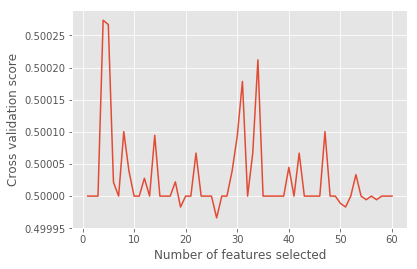

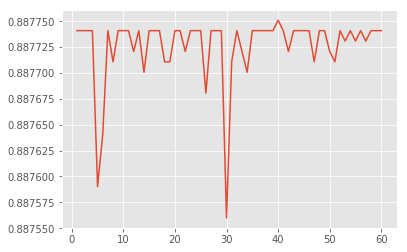

IndexError: boolean index did not match indexed array along dimension 0; dimension is 17 but corresponding boolean dimension is 60

In [196]:
import matplotlib.pyplot as plt
import warnings
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from numpy.random import RandomState

if 'readmitted' in diabetic:
    y = diabetic['readmitted'].values # get the labels we want
    del diabetic['readmitted'] # get rid of the class label
    X = diabetic.values # use everything else to predict!
    dataLabels = diabetic.columns

# Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear
# rather than libsvm, so it has more flexibility in the choice of penalties and loss
# functions and should scale better to large numbers of samples.
svc = LinearSVC(class_weight = 'balanced', # adjust weights inversely proportional to class frequencies in the data set
                fit_intercept = False, #  If set to false, no intercept will be used in calculations
                                       # (i.e. data is expected to be already centered).
                max_iter = 11, # default=1000
                penalty = 'l2', # The ‘l1’ leads to coef_ vectors that are sparse.
                dual = False,
                random_state = rState)

# The “saga” solver is a variant of “sag” that also supports the non-smooth penalty=”l1” option.
# This is therefore the solver of choice for sparse multinomial logistic regression.
# A logistic regression with L1 penalty yields sparse models, and can thus be used to perform feature selection.
# https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lr_clf = LogisticRegression(penalty      = 'l1',
                            C            = 100,
                            class_weight = 'balanced', # “balanced” automatically adjust weights inversely proportional to class frequencies
                            solver       = 'saga',
                            multi_class  = 'ovr', # ’ovr’: a binary problem is fit for each label
                            max_iter     = 500 # default 100
                           )


xgb = XGBClassifier().set_params(**paramsDict['f1'])

num_cv_iterations = 5
cv_object         = ShuffleSplit(n_splits = num_cv_iterations,
                                 test_size = 0.2,
                                 random_state = rState)

rfecv = RFECV(estimator = xgb,
              step = 1,
              cv = 5, # number of folds for a KFold CV.
              scoring='balanced_accuracy', # balanced_accuracy is to deal with imbalanced datasets. 
                                           # It is defined as the average of recall obtained on each class.
              n_jobs = -1, # Use all available processor cores
              verbose = 2)

rfecv_acc = RFECV(estimator = xgb,
              step = 1,
              cv = 5, # number of folds for a KFold CV.
              scoring='accuracy', # balanced_accuracy is to deal with imbalanced datasets. 
                                           # It is defined as the average of recall obtained on each class.
              n_jobs = -1, # Use all available processor cores
              verbose = 2)

# Catch all the non convergence warnings.
with warnings.catch_warnings(record = True) as warn:
    rfecv.fit(X, y)
    rfecv_acc.fit(X, y)
    print("Warnings:", len(warn))

print("Optimal number of features: %d" % rfecv.n_features_)
print("Optimal number of features acc: %d" % rfecv_acc.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) * rfecv.get_params()['step'] + 1, rfecv.get_params()['step']),
         rfecv.grid_scores_)
plt.show()

plt.plot(range(1, len(rfecv_acc.grid_scores_) * rfecv_acc.get_params()['step'] + 1, rfecv_acc.get_params()['step']),
         rfecv_acc.grid_scores_)
plt.show()

dataLabels = dataLabels[rfecv.support_]

print(tabulate({"Remaining Features": dataLabels}, headers = 'keys'))

In [80]:

X = rfecv.transform(X)
print(tabulate({"Remaining Features": dataLabels}, headers = 'keys'))

Remaining Features
---------------------------
discharge_disposition_id_6
discharge_disposition_id_11
discharge_disposition_id_13
discharge_disposition_id_14
discharge_disposition_id_22
admission_type_id_2
admission_type_id_3
admission_type_id_5
admission_type_id_6
admission_source_id_4
admission_source_id_6
admission_source_id_7
insulin_No
insulin_Steady
insulin_Up
race_Caucasian
gender_Male
diabetesMed_Yes
age
time_in_hospital
number_diagnoses


In [99]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.5, random_state = rState)

xgb.fit(X_train, y_train)

y_true, y_pred = y_test, xgb.predict(X_test)
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.60      0.63      0.62     26535
           1       0.55      0.52      0.54     23212

   micro avg       0.58      0.58      0.58     49747
   macro avg       0.58      0.58      0.58     49747
weighted avg       0.58      0.58      0.58     49747



In [208]:
lr_clf.fit(X_train_trans, y_train)
lr_ytrue, lr_ypred = y_test, lr_clf.predict(X_test_trans)
print(classification_report(lr_ytrue, lr_ypred))

              precision    recall  f1-score   support

           0       0.90      0.64      0.75     58883
           1       0.14      0.46      0.22      7446

   micro avg       0.62      0.62      0.62     66329
   macro avg       0.52      0.55      0.48     66329
weighted avg       0.82      0.62      0.69     66329



In [211]:
lr_clf.coef_

array([[ 0.3853696 ,  1.14411898, -0.03535726,  0.12850667]])

array([3.44460215e-15, 2.94211729e-37, 2.27896441e-02, 1.42085389e-14])

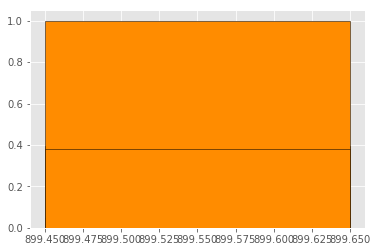

In [225]:

from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=90)
selector.fit(X_train_trans, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(900 - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')
selector.pvalues_

In [ ]:
def my_score(y, y_)

In [203]:
#X_train_trans = rfecv.transform(X_train)
X_test_trans = rfecv.transform(X_test)

In [201]:
len(X_train_trans[0])

4

Build a text report showing the main classification metrics

    Read more in the :ref:`User Guide <classification_report>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.

    labels : array, shape = [n_labels]
        Optional list of label indices to include in the report.

    target_names : list of strings
        Optional display names matching the labels (same order).

    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.

    digits : int
        Number of digits for formatting output floating point values.
        When ``output_dict`` is ``True``, this will be ignored and the
        returned values will not be rounded.

    output_dict : bool (default = False)
        If True, return output as dict

    Returns
    -------

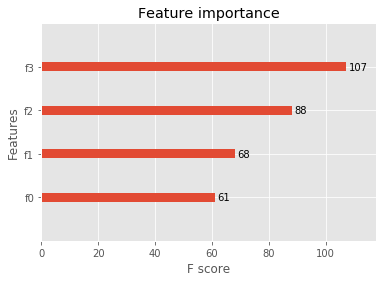

In [204]:
from xgboost import XGBRegressor
xgbr = XGBRegressor()
xgbr.set_params(**xgb.get_params())
xgbr.fit(X_train_trans, y_train)
gblr_ytrue, gblr_ypred = y_test, xgbr.predict(X_test_trans)

print(classification_report.__doc__)
plot_importance(xgbr)

AttributeError: 'XGBRegressor' object has no attribute 'evals_result_'

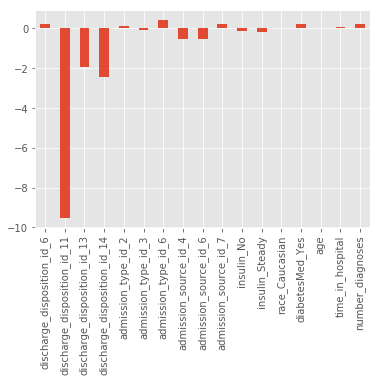

In [150]:
weights = pd.Series(lr_clf.coef_[0], index=dataLabels)
weights.plot(kind='bar')
plt.show()

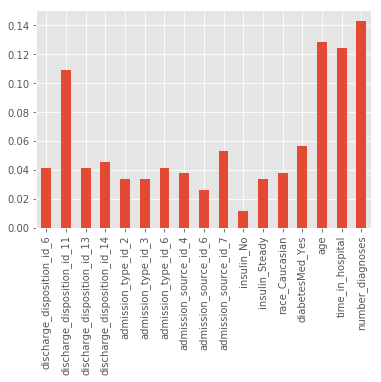

In [114]:
plt.style.use('ggplot')


weights = pd.Series(xgb.feature_importances_,index=dataLabels)
weights.plot(kind='bar')
plt.show()

In [115]:
xgb.feature_importances_

array([0.04150943, 0.10943396, 0.04150943, 0.04528302, 0.03396226,
       0.03396226, 0.04150943, 0.03773585, 0.02641509, 0.05283019,
       0.01132075, 0.03396226, 0.03773585, 0.05660377, 0.12830189,
       0.1245283 , 0.14339623], dtype=float32)

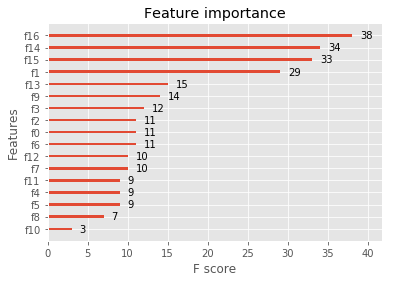

In [117]:
import pickle
from xgboost import XGBClassifier, plot_importance
plot_importance(xgb)

Plot importance based on fitted trees.

    Parameters
    ----------
    booster : Booster, XGBModel or dict
        Booster or XGBModel instance, or dict taken by Booster.get_fscore()
    ax : matplotlib Axes, default None
        Target axes instance. If None, new figure and axes will be created.
    grid : bool, Turn the axes grids on or off.  Default is True (On).
    importance_type : str, default "weight"
        How the importance is calculated: either "weight", "gain", or "cover"

        * "weight" is the number of times a feature appears in a tree
        * "gain" is the average gain of splits which use the feature
        * "cover" is the average coverage of splits which use the feature
          where coverage is defined as the number of samples affected by the split
    max_num_features : int, default None
        Maximum number of top features displayed on plot. If None, all features will be displayed.
    height : float, default 0.2
        Bar height, passed to ax.barh

{'f1': 29,
 'f16': 38,
 'f9': 14,
 'f5': 9,
 'f6': 11,
 'f14': 34,
 'f0': 11,
 'f15': 33,
 'f7': 10,
 'f13': 15,
 'f2': 11,
 'f3': 12,
 'f8': 7,
 'f4': 9,
 'f12': 10,
 'f11': 9,
 'f10': 3}

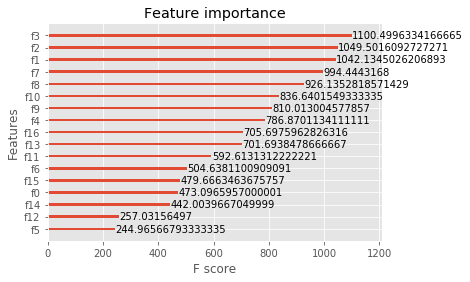

In [134]:
print(plot_importance.__doc__)
plot_importance(xgb, importance_type="cover")
xgb.get_booster().get_fscore()